# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import os
os.environ['JAVA_HOME'] = '/workspace/jdk'
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}/bin:{os.environ['PATH']}"

In [4]:
# create a Spark session

spark = SparkSession.builder.appName("Sparkify Project").getOrCreate()

/opt/venv/lib/python3.10/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/09 05:37:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df = spark.read.json("mini_sparkify_event_data.json")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [14]:
#Compute the number of row in the dataframe
print("The total number of rows in the dataframe is {}".format(df.count()))

#Compute the number of columns in the dataframe
print("The total number of column in the dataframe is {}".format(len(df.columns)))

The total number of rows in the dataframe is 286500
The total number of column in the dataframe is 18


In [10]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [18]:
#We provide a detailed description of the dataframe's column

df.describe(df.columns[:6]).show()
df.describe(df.columns[6:13]).show()
df.describe(df.columns[13:]).show()

+-------+------------------+----------+---------+------+------------------+--------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|
+-------+------------------+----------+---------+------+------------------+--------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|
|   mean| 551.0852017937219|      NULL|     NULL|  NULL|114.41421291448516|    NULL|
| stddev|1217.7693079161374|      NULL|     NULL|  NULL|129.76726201140994|    NULL|
|    min|               !!!| Cancelled| Adelaida|     F|                 0|   Adams|
|    max| ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1321|  Wright|
+-------+------------------+----------+---------+------+------------------+--------+



+-------+-----------------+------+-----------------+------+-------+--------------------+-----------------+
|summary|           length| level|         location|method|   page|        registration|        sessionId|
+-------+-----------------+------+-----------------+------+-------+--------------------+-----------------+
|  count|           228108|286500|           278154|286500| 286500|              278154|           286500|
|   mean|249.1171819778458|  NULL|             NULL|  NULL|   NULL|1.535358834084427...|1041.526554973822|
| stddev|99.23517921058361|  NULL|             NULL|  NULL|   NULL| 3.291321616327586E9|726.7762634630741|
|    min|          0.78322|  free|       Albany, OR|   GET|  About|       1521380675000|                1|
|    max|       3024.66567|  paid|Winston-Salem, NC|   PUT|Upgrade|       1543247354000|             2474|
+-------+-----------------+------+-----------------+------+-------+--------------------+-----------------+



+-------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|                song|            status|                  ts|           userAgent|           userId|
+-------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|              228108|            286500|              286500|              278154|           286500|
|   mean|            Infinity|210.05459685863875|1.540956889810483...|                NULL|59682.02278593872|
| stddev|                 NaN| 31.50507848842214|1.5075439608226302E9|                NULL|109091.9499991047|
|    min|ÃÂg ÃÂtti Gr...|               200|       1538352117000|"Mozilla/5.0 (Mac...|                 |
|    max|ÃÂau hafa slopp...|               404|       1543799476000|Mozilla/5.0 (comp...|               99|
+-------+--------------------+------------------+--------------------+--------------------+-----------------+



In [8]:
def info(df):
    info = pd.DataFrame(columns = ['Feature','#Nullvalues','#Empetystring','#NonNullvalues','%Non-nullvalues'])
    #Here we try tocheck for the number of null rows in each column
    i = 0
    row_count = df.count()
    for col in df.columns:
        null_count = df.filter(isnull(df[col])).count()
        emptystring_count = df.filter(df[col].isin('')).count()
        info.loc[i] = [col,null_count,emptystring_count,(row_count-null_count),(row_count-null_count)/row_count]
        i +=1
    print(info)

In [9]:
info(df)

          Feature  #Nullvalues  #Empetystring  #NonNullvalues  %Non-nullvalues
0          artist        58392              0          228108         0.796188
1            auth            0              0          286500         1.000000
2       firstName         8346              0          278154         0.970869
3          gender         8346              0          278154         0.970869
4   itemInSession            0              0          286500         1.000000
5        lastName         8346              0          278154         0.970869
6          length        58392              0          228108         0.796188
7           level            0              0          286500         1.000000
8        location         8346              0          278154         0.970869
9          method            0              0          286500         1.000000
10           page            0              0          286500         1.000000
11   registration         8346              0       

In [19]:
# drop rows with missing values in userid and/or sessionid
df = df.dropna(how = 'any', subset = ["userId", "sessionId"])

In [20]:
#Remove records with empth userId string
df = df.filter(df['userId'] != '')

In [21]:
print("The number of rows in the remaining dataframe is {}".format(df.count()))

The number of rows in the remaining dataframe is 278154


In [25]:
print("The number of distinct records in our dataframe is {}".format(df.distinct().count()))

The number of distinct records in our dataframe is 278154


## Exploratory Data Analysis
<a class="anchor" id="eda"></a>

### Define Churn

A column `Churn` will be created to use as the label for our model. `Cancellation Confirmation` events is used to define churn, which happen for both paid and free users. We will assign a 1 where a user has churned and a 0 where they have not churned.

### Explore Data
Exploratory data analysis will  be performed to observe the behavior for users who stayed vs users who churned. Starting by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [30]:
# number of users who churned
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

In [31]:
# add a new column "churn_value" to mark cancellation event
churn_value = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn("churn_value", churn_value("page"))

In [32]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn_value=0)

In [33]:
# label users who have churned
churn_window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("user_churn", sum('churn_value').over(churn_window))

Text(0.5, 0, 'Subscription status')

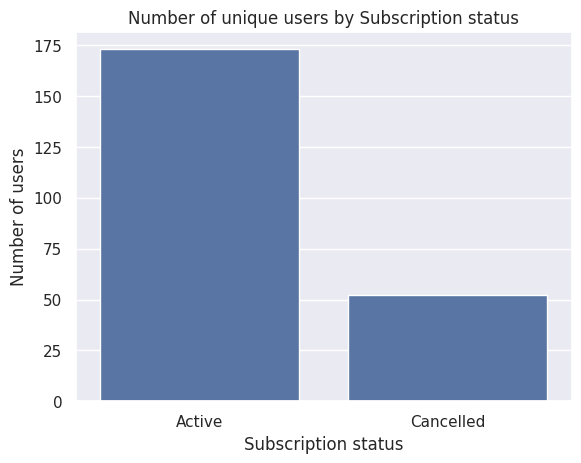

In [34]:
# We plot the unique number of users according to the subscription status
plt.grid(True)
df_ch_pd = df.drop_duplicates(['userId']).groupby(['user_churn']).count().sort("user_churn").toPandas()
sns.barplot(data =df_ch_pd, x = 'user_churn',y = 'count')
churn_d = ['Active', 'Cancelled']
x_pos = np.arange(len(churn_d))
plt.xticks(x_pos,churn_d)
plt.title('Number of unique users by Subscription status')
plt.ylabel('Number of users')
plt.xlabel('Subscription status')

Text(0.5, 0, 'Subscription status')

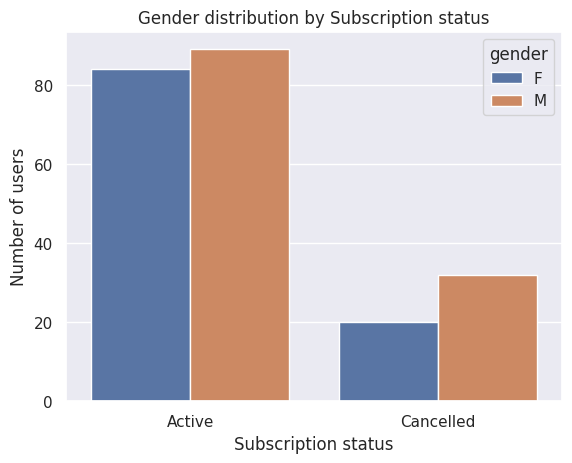

In [35]:
# Plotting a bar plot to show gender distribution by Subscription status
plt.grid(True)
df_ch_pd = df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").toPandas()
sns.barplot(x = 'user_churn', y = 'count', data = df_ch_pd, hue = 'gender')
churn_d = ['Active', 'Cancelled']
y_pos = np.arange(len(churn_d))
plt.xticks(y_pos,churn_d)
plt.title("Gender distribution by Subscription status")
plt.ylabel('Number of users')
plt.xlabel('Subscription status')

Text(0.5, 0, 'Subscription status')

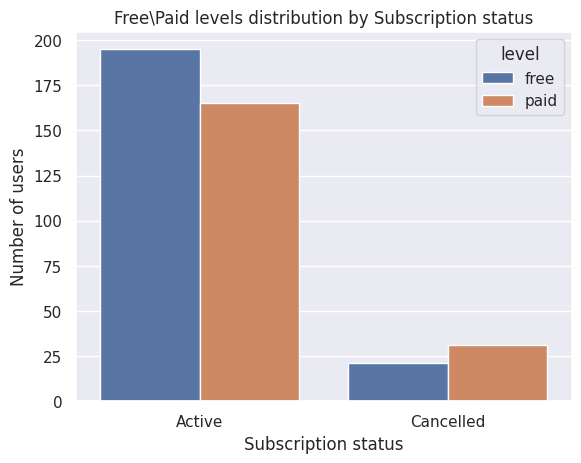

In [36]:
# Plotting a bar plot to show level distribution by Subscription status
plt.grid(True)
level_df = df.drop_duplicates(['userId','churn_value', 'level']).groupby(['churn_value', 'level']).count().sort("churn_value").toPandas()
sns.barplot(x = 'churn_value', y = 'count', data = level_df, hue = 'level')
churn_d = ['Active', 'Cancelled']
x_pos = np.arange(len(churn_d))
plt.xticks(x_pos,churn_d)
plt.title("Free\Paid levels distribution by Subscription status")
plt.ylabel('Number of users')
plt.xlabel('Subscription status')

We can now turn our attention to calculating the number of songs listened to by churn and non churn users per hour. 

In [55]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df = df.withColumn("hour", get_hour(df.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df = df.withColumn("weekday", get_weekday(df.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df = df.withColumn("day", get_day(df.ts))

In [56]:
df.head()

Row(artist='Sea Wolf', auth='Logged In', firstName='Brycen', gender='M', itemInSession=0, lastName='Bradley', length=265.53424, level='paid', location='Laurel, MS', method='PUT', page='NextSong', registration=1538159495000, sessionId=9, song='Ses Monuments', status=200, ts=1538965220000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='10', churn_value=0, user_churn=0, hour='2', weekday='1', day='8')

In [58]:
# create a df with those who didnt churn and which counts when user goes to next song page
songs_in_hour_stay = df.filter((df.page == "NextSong") & (df.user_churn == 0)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [59]:
songs_in_hour_stay.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0| 7527|
|   1| 7035|
|   2| 7014|
|   3| 7063|
|   4| 6914|
|   5| 6960|
|   6| 6836|
|   7| 6873|
|   8| 7023|
|   9| 7268|
|  10| 7502|
|  11| 7440|
|  12| 7918|
|  13| 8073|
|  14| 8792|
|  15| 9462|
|  16| 9721|
|  17| 9464|
|  18| 9146|
|  19| 9112|
|  20| 9107|
|  21| 8853|
|  22| 8526|
|  23| 8085|
+----+-----+



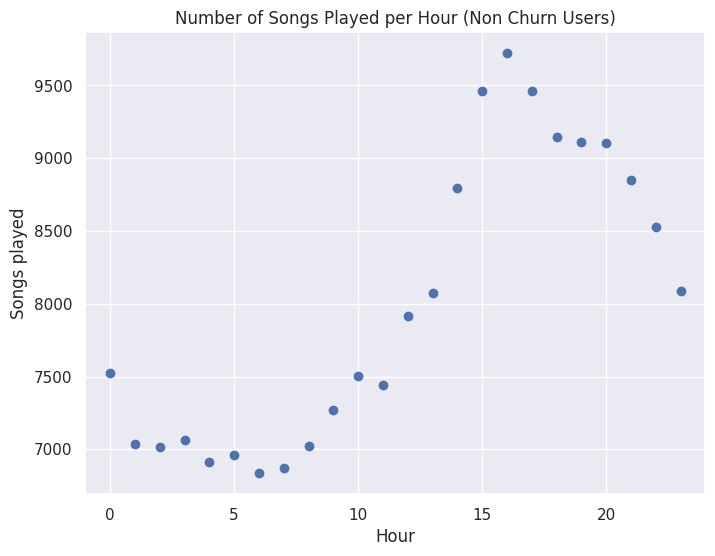

In [60]:
# convert to pandas and then to numeric
songs_in_hour_stay_pd = songs_in_hour_stay.toPandas()
songs_in_hour_stay_pd.hour = pd.to_numeric(songs_in_hour_stay_pd.hour)

#plot the distribution
plt.figure(figsize = [8,6])
plt.scatter(songs_in_hour_stay_pd["hour"], songs_in_hour_stay_pd["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour (Non Churn Users)");

We observe from the above a peak of song played between 15 to 20.

In [65]:
# dataframe with customers who churned and count next song page 
songs_in_hour_churned = df.filter((df.page == "NextSong") & (df.user_churn == 1)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [66]:
songs_in_hour_churned.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 1535|
|   1| 1353|
|   2| 1322|
|   3| 1292|
|   4| 1233|
|   5| 1218|
|   6| 1218|
|   7| 1218|
|   8| 1230|
|   9| 1230|
|  10| 1380|
|  11| 1390|
|  12| 1408|
|  13| 1571|
|  14| 1702|
|  15| 1892|
|  16| 1915|
|  17| 1996|
|  18| 1978|
|  19| 1818|
+----+-----+
only showing top 20 rows



In [67]:
# convert to pandas and to numeric
songs_in_hour_churned = songs_in_hour_churned.toPandas()
songs_in_hour_churned.hour = pd.to_numeric(songs_in_hour_churned.hour)

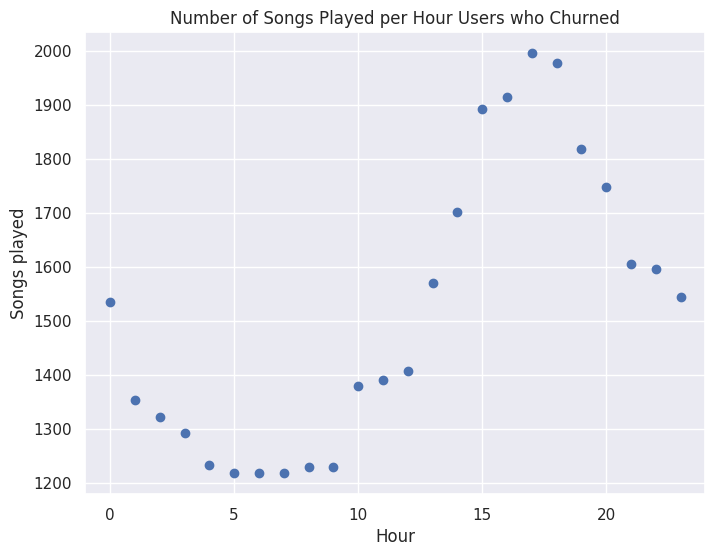

In [68]:
#plot distribution of songs per hour for churned
plt.figure(figsize = [8,6])
plt.scatter(songs_in_hour_churned["hour"], songs_in_hour_churned["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour Users who Churned");

We observe a similar distribution with the non churn users. However the number of songs played by the churn users is significally higher. 

# Feature Engineering

The features we will build out are:
 - gender 
 - Total number of  songs listened
 - Total time spent 
 - number of thumb down actions
 - number of thumbs up actions
 - number of songs added to playlist
 - Number of lifetime
 - number of friends added
 - Total number of songs listened per session
 - number of different artists listened to
 
We will also then add a churn label and join these all together. This will create a dataFrame where each row represents information pertaining to each individual user. Once we drop the userId, this dataframe can be vectorised, standarised and fed into our different machine learning algorithms.

In [90]:
#Feature1: Gender

feat_1 = df.select(['userId', 'gender']).dropDuplicates()
feat_1 = gender_f1.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [91]:
# Feature 2 : Total number of  songs listened
feat_2 = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'tot_songs')

In [92]:
# Feature 3 : Total time spent 
feat_3 = df.select('userID','length').groupBy('userID').agg({'length':'sum'}).withColumnRenamed('sum(length)', 'listen_time')

In [93]:
# Feature 4 : Number of thumbs-up
feat_4 = df.select('userID','page').where(df.page == 'Thumbs Up').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'num_thumb_up')

#Feature 5 : Number thumbs-down
feat_5 = df .select('userID','page').where(df.page == 'Thumbs Down').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'num_thumb_down')

In [94]:
# Feature 6 : Number of adds to playlist
feat_6 = df.select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'add_to_playlist')

In [95]:
# Feature 7 : Number of lifetime
feat_7 = df.select('userID','registration','ts').withColumn('lifetime',(df.ts-df.registration)).groupBy('userID').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lt')

In [96]:
# Feature 8 : Total number of friends
feat_8 = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'tot_friends')

In [97]:
# Feature 10 : Total number of songs listened per session
feat_9  = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'avg_played_songs')

In [98]:
# Feature 11 : Total number of artists the user has listened to
feat_10 = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "tot_artist_played")

In [99]:
# setting the churn label for our model
target = df.select('userId', col('user_churn').alias('label')).dropDuplicates()

In [100]:
# Combining all features with the target churn label
final_data  = feat_1.join(feat_2,'userID','outer') \
    .join(feat_3,'userID','outer') \
    .join(feat_4,'userID','outer') \
    .join(feat_5,'userID','outer') \
    .join(feat_6,'userID','outer') \
    .join(feat_7,'userID','outer') \
    .join(feat_8,'userID','outer') \
    .join(feat_9,'userID','outer') \
    .join(feat_10,'userID','outer') \
    .join(target,'userID','outer') \
    .drop('userID') \
    .fillna(0)

In [101]:
final_data.show(5)

+------+---------+------------------+------------+--------------+---------------+-----------+-----------+------------------+-----------------+-----+
|gender|tot_songs|       listen_time|num_thumb_up|num_thumb_down|add_to_playlist|         lt|tot_friends|  avg_played_songs|tot_artist_played|label|
+------+---------+------------------+------------+--------------+---------------+-----------+-----------+------------------+-----------------+-----+
|     0|      795|166866.37251000004|          37|             4|              9| 4472293000|         12|112.16666666666667|              565|    0|
|     0|     3214|  672877.856590001|         148|            27|             61| 5605094000|         49| 78.88235294117646|             1705|    0|
|     0|      187|35073.742150000005|           8|             2|              3| 3870739000|          2|             33.25|              125|    1|
|     0|      218| 49559.91809999999|           5|             0|              5|13864787000|          1| 

In [102]:
incol = ['gender','tot_songs',
 'listen_time',
 'num_thumb_up',
 'num_thumb_down',
 'add_to_playlist',
 'lt',
 'tot_friends',
 'avg_played_songs',
 'tot_artist_played']
assembler = VectorAssembler(inputCols=incol, outputCol="NumFeatures")
final_data = assembler.transform(final_data)

In [103]:
scaler2 = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler2.fit(final_data)
final_data = scalerModel.transform(final_data)

In [104]:
final_data.take(2)

[Row(gender=0, tot_songs=795, listen_time=166866.37251000004, num_thumb_up=37, num_thumb_down=4, add_to_playlist=9, lt=4472293000, tot_friends=12, avg_played_songs=112.16666666666667, tot_artist_played=565, label=0, NumFeatures=DenseVector([0.0, 795.0, 166866.3725, 37.0, 4.0, 9.0, 4472293000.0, 12.0, 112.1667, 565.0]), features=DenseVector([0.0, 0.598, 0.6059, 0.5651, 0.3059, 0.2751, 1.3744, 0.583, 2.6321, 0.9355])),
 Row(gender=0, tot_songs=3214, listen_time=672877.856590001, num_thumb_up=148, num_thumb_down=27, add_to_playlist=61, lt=5605094000, tot_friends=49, avg_played_songs=78.88235294117646, tot_artist_played=1705, label=0, NumFeatures=DenseVector([0.0, 3214.0, 672877.8566, 148.0, 27.0, 61.0, 5605094000.0, 49.0, 78.8824, 1705.0]), features=DenseVector([0.0, 2.4174, 2.4433, 2.2603, 2.0646, 1.8645, 1.7226, 2.3808, 1.851, 2.8231]))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [106]:
final_data2 = final_data.select('label','features')
final_data2.take(1)

[Row(label=0, features=DenseVector([0.0, 0.598, 0.6059, 0.5651, 0.3059, 0.2751, 1.3744, 0.583, 2.6321, 0.9355]))]

In [108]:
train,validation = final_data2.randomSplit([0.8, 0.2], seed=50)

In [109]:
# Models to train: logistic regression, svm, gradient boosting tree
logistic_reg = LogisticRegression(maxIter=10, regParam =0.0)
gbt = GBTClassifier(maxDepth = 5, maxIter = 10, seed = 42)
svm = LinearSVC (maxIter = 10,  regParam = 0.01) 

In [110]:
#Logistic Regression
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(logistic_reg.regParam,[0.0, 0.05, 0.1]) \
    .build()
crossval = CrossValidator(estimator=logistic_reg,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q1 = crossval.fit(train)
cvModel_q1.avgMetrics

24/09/09 07:27:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/09 07:27:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


[0.799960219226334, 0.7158204779023712, 0.6967849671525838]

In [111]:
# Support Vector Machine 
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam,[0.01, 0.05, 0.5]) \
    .build()
crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q2 = crossval.fit(train)
cvModel_q2.avgMetrics

[0.7022765108491001, 0.6856905346959222, 0.6914726667938438]

In [112]:
gbt_tuned = GBTClassifier(maxDepth=5,maxIter=10,seed=42)
gbt_model = gbt_tuned.fit(train)
results = gbt_model.transform(validation)

In [113]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))

0.75


In [114]:
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

0.7429467084639498


In [115]:
gbt_model.featureImportances

SparseVector(10, {1: 0.1999, 2: 0.0118, 3: 0.0666, 4: 0.1982, 5: 0.0541, 6: 0.2595, 7: 0.0301, 8: 0.1594, 9: 0.0204})

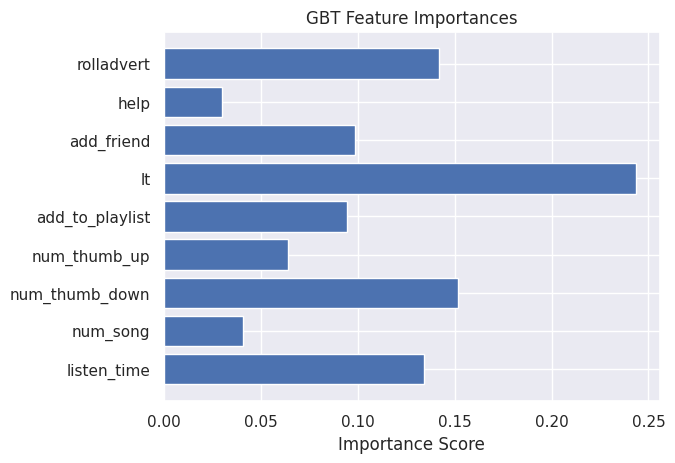

In [116]:
importances  = [ 0.134,0.0408,0.1519,0.0639,0.0946,0.2436,0.0988,0.0301,0.1421]
feature = ["listen_time", "num_song", "num_thumb_down", \
          'num_thumb_up','add_to_playlist','lt','add_friend','help','rolladvert']
y_pos = np.arange(len(feature))
 
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, feature)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances')
plt.savefig('GBT feature Importance.png', dpi=300)

# Conclusion

We started the project with a small dataset of just 128MB. After loading and cleaning our data we explored the dataset for useful features to predict churn and were able to build out the most promising features. We then preprocessed these and used the features with three different machine learning models. Logistic Regression the best, Support Vector Machine and Gradient-Boosted Trees.

for comparison

F1-Score on the validation set
- 0.8 For Logistic Regression Model
- 0.7 For Support Vector Machine
- 0.74 For Gradient Boosted Trees


Sparkify can use our model to target customers who are likely to churn and offer attractive incentives to stay to prevent them from cancelling the service. I think attention should we be paid on how to deal with mispredicted users, because offering discount to falsely classified users can be expensive for the company in the long term. I also think that more feature engieering should be done in order to extract relevant features for our model. It will also be important to analyse the life cycle of the users, in order to get understand the timing of the churn decision.


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.